In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 35.1 MB/s eta 0:00:00


# Librerias necesarias

In [17]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Función para obtener propiedades de las moléculas

In [3]:
# Asegúrate de que la función de análisis de moléculas esté definida
def analizar_molecula(smiles: str):
    """
    Analiza una molécula a partir de su cadena SMILES y devuelve sus propiedades clave.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        return {
            "Aceptores_H": Descriptors.NumHAcceptors(mol),
            "Donantes_H": Descriptors.NumHDonors(mol),
            "logP": Descriptors.MolLogP(mol),
            "Peso_Molecular": Descriptors.MolWt(mol)
        }
    except Exception:
        return None

In [14]:
from rdkit import Chem
from IPython.display import display

def visualizar_molecula(smiles: str):
    """
    Lee una cadena SMILES y muestra la visualización 2D de la molécula.

    Args:
        smiles (str): La cadena SMILES de la molécula a visualizar.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print("Error: SMILES inválido. No se puede visualizar la molécula.")
            return

        print(f"Visualizando la molécula con SMILES: {smiles}")
        display(mol)

    except Exception as e:
        print(f"Ocurrió un error inesperado al visualizar: {e}")


## Dataset de compuestos de entrenamiento

In [4]:
dataset_compuestos = {
    "Agua": "O",
    "Etanol": "CCO",
    "Metanol": "CO",
    "Acetona": "CC(=O)C",
    "Acetato de etilo": "CCOC(=O)C",
    "Hexano": "CCCCCC",
    "Benceno": "c1ccccc1",
    "Tolueno": "Cc1ccccc1",
    "Cloroformo": "C(Cl)(Cl)Cl",
    "Dietil éter": "CCOCC",
    "Acetonitrilo": "CC#N",
    "Dimetilsulfóxido (DMSO)": "CS(=O)C",
    "Tetrahidrofurano (THF)": "C1CCOC1",
    "Propanol": "CCCCO",
    "Glicerol": "C(C(CO)O)O",
    "Ácido acético": "CC(=O)O",
    "Etilenglicol": "C(CO)O",
    "Dioxano": "C1COCCO1",
    "Piridina": "c1ccncc1",
    "Ácido fórmico": "C(=O)O",
    "Ciclohexano": "C1CCCCC1",
    "Éter de petróleo": "CCCCC",
    "Heptano": "CCCCCC",
    "Xileno": "Cc1cccc(C)c1",
    "Anilina": "Nc1ccccc1",
    "Fenol": "Oc1ccccc1",
    "Benzaldehído": "O=Cc1ccccc1",
    "Ácido benzoico": "O=C(O)c1ccccc1",
    "Nitroetano": "CC[N+](=O)[O-]",
    "Ácido láctico": "CC(O)C(=O)O",
    "Propanona": "CCC(=O)C",
    "Butanol": "CCCCO",
    "Pentanol": "CCCCCO",
    "Hexanol": "CCCCCCO",
    "Heptanol": "CCCCCCC",
    "Dodecanol": "CCCCCCCCCCCC",
    "Ácido oxálico": "O=C(O)C(=O)O",
    "Ácido cítrico": "C(C(=O)O)C(CC(=O)O)(O)C(=O)O",
    "Ácido tartárico": "C(C(C(=O)O)O)(C(=O)O)O",
    "Metil isobutil cetona (MIBK)": "CC(C)CC(=O)C",
    "Benceno-1,2-diol (Catecol)": "Oc1c(O)cccc1",
    "Benceno-1,3-diol (Resorcinol)": "Oc1cc(O)ccc1",
    "Benceno-1,4-diol (Hidroquinona)": "Oc1ccc(O)cc1",
    "Galato de metilo": "COC(=O)c1cc(O)c(O)c(O)c1",
    "Rutina": "OC1OC(c2cc(OC3OC(CO)C(O)C(O)C3O)c(O)c(O)c2O)C(O)C(O)C1O",
    "Quercetina": "O=C1c2c(O)cc(O)c(O)c2OC(c2ccc(O)c(O)c2)C1O",
    "Ácido rosmarínico": "O=C(O)C(O)c1ccc(O)c(O)c1c1c(O)cc(O)c(C=CC(=O)O)c1",
    "Eugenol": "COc1cc(C=C)ccc1O",
    "Mentol": "CC(C)C1CCC(O)CC1",
    "Timol": "CC(C)c1ccc(O)c(C)c1"
}

# Tabla con datos de entrenamiento

In [5]:
# 2. Generar el dataset
data_rows = []
for nombre, smiles in dataset_compuestos.items():
    propiedades = analizar_molecula(smiles)
    if propiedades:
        fila = {
            'Nombre': nombre,
            'SMILES': smiles,
            **propiedades
        }
        data_rows.append(fila)

df_dataset = pd.DataFrame(data_rows)

# 3. Asignar etiquetas de extracción (variable a predecir)
# Regla simple: si tiene al menos 1 donador de H, 1 aceptor de H y un logP < 3,
# lo consideramos un buen extractor (1). De lo contrario, es un mal extractor (0).
df_dataset['Extraccion'] = df_dataset.apply(
    lambda row: 1 if row['Aceptores_H'] >= 1 and row['Donantes_H'] >= 1 and row['logP'] < 3.0 else 0,
    axis=1
)

print("--- Vista previa del Dataset ---")
df_dataset[['Nombre', 'Aceptores_H', 'Donantes_H', 'logP', 'Extraccion']].head()


--- Vista previa del Dataset ---


,Nombre,Aceptores_H,Donantes_H,logP,Extraccion
0,Agua,0,0,-0.8247,0
1,Etanol,1,1,-0.0014,1
2,Metanol,1,1,-0.3915,1
3,Acetona,1,0,0.5953,0
4,Acetato de etilo,2,0,0.5694,0


# Entrenamiento del modelo

In [6]:
### Entrenamiento y Evaluación de la Red Neuronal

# 1. Separar los datos en características (X) y etiquetas (y)
features = ['Aceptores_H', 'Donantes_H', 'logP', 'Peso_Molecular']
X = df_dataset[features]
y = df_dataset['Extraccion']

# 2. Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("\n--- Tamaño de los conjuntos ---")
print(f"Conjunto de entrenamiento: {len(X_train)} muestras")
print(f"Conjunto de prueba: {len(X_test)} muestras")

# 3. Entrenar el modelo de red neuronal
# MLPClassifier es un Perceptrón Multicapa, un modelo de red neuronal básico.
model = MLPClassifier(
    hidden_layer_sizes=(10, 5), # 2 capas ocultas con 10 y 5 neuronas
    max_iter=1000,
    random_state=1,
    solver='adam' # Algoritmo de optimización
)
model.fit(X_train, y_train)


--- Tamaño de los conjuntos ---
Conjunto de entrenamiento: 35 muestras
Conjunto de prueba: 15 muestras


MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=1000, random_state=1)

Iteration 1, loss = 11.40562688
Iteration 2, loss = 11.25434029
Iteration 3, loss = 11.05975830
Iteration 4, loss = 10.87590398
Iteration 5, loss = 10.68482142
Iteration 6, loss = 10.49206550
Iteration 7, loss = 10.29935195
Iteration 8, loss = 10.10593171
Iteration 9, loss = 9.91255306
Iteration 10, loss = 9.71923951
Iteration 11, loss = 9.52597537
Iteration 12, loss = 9.33289452
Iteration 13, loss = 9.14001618
Iteration 14, loss = 8.94739726
Iteration 15, loss = 8.75505507
Iteration 16, loss = 8.56301385
Iteration 17, loss = 8.37423295
Iteration 18, loss = 8.19646668
Iteration 19, loss = 8.02561635
Iteration 20, loss = 7.85598586
Iteration 21, loss = 7.68724946
Iteration 22, loss = 7.51883613
Iteration 23, loss = 7.31933210
Iteration 24, loss = 7.12346776
Iteration 25, loss = 6.92830527
Iteration 26, loss = 6.73396250
Iteration 27, loss = 6.54021497
Iteration 28, loss = 6.34687153
Iteration 29, loss = 6.15375343
Iteration 30, loss = 5.96085495
Iteration 31, loss = 5.76809538
Iteration

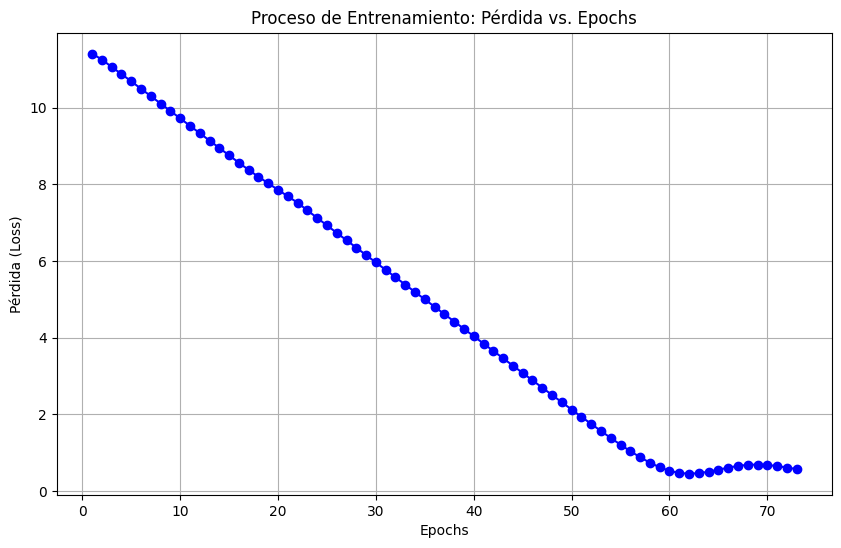

In [21]:
# 3. Entrenar el modelo de red neuronal
model = MLPClassifier(
    hidden_layer_sizes=(10, 5),
    max_iter=100,
    random_state=1,
    solver='adam',
    verbose=True
)
model.fit(X_train, y_train)

# ---
### Gráfico del proceso de entrenamiento

# Obtener la lista de pérdidas de entrenamiento del atributo 'loss_curve_' del modelo
loss_values = model.loss_curve_

# Crear un rango de números de epoch (desde 1 hasta el número de iteraciones)
epochs = range(1, len(loss_values) + 1)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, 'o-', color='blue') # 'o-' crea un gráfico de puntos y líneas
plt.title('Proceso de Entrenamiento: Pérdida vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Pérdida (Loss)')
plt.grid(True)
plt.show()

# Evaluación del modelo

In [7]:
# 4. Evaluar el modelo
y_pred = model.predict(X_test)
precision = accuracy_score(y_test, y_pred)

print("\n--- Resultados del Entrenamiento ---")
print(f"Precisión del modelo en el conjunto de prueba: {precision * 100:.2f}%")


--- Resultados del Entrenamiento ---
Precisión del modelo en el conjunto de prueba: 73.33%


# Prueba de moléculas interesantes como solventes

Visualizando la molécula con SMILES: CCCCCCCC#CCCCCCCCC


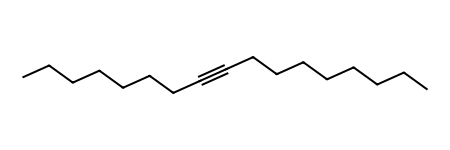


--- Predicción para un nuevo compuesto ---
SMILES: CCCCCCCC#CCCCCCCCC
Propiedades calculadas: {'Aceptores_H': 0, 'Donantes_H': 0, 'logP': 6.100900000000006, 'Peso_Molecular': 236.4429999999999}
El modelo predice que es un MAL extractor.


In [15]:
# 1. Definir la cadena SMILES del nuevo compuesto a predecir
smiles_nuevo_compuesto = "CCCCCCCC#CCCCCCCCC"
visualizar_molecula(smiles_nuevo_compuesto)

# 2. Usar la función para analizar el nuevo compuesto
propiedades_nuevo = analizar_molecula(smiles_nuevo_compuesto)

if propiedades_nuevo:
    # 3. Crear el DataFrame para la predicción
    nuevo_compuesto_df = pd.DataFrame([propiedades_nuevo], columns=features)

    # 4. Usar el modelo para hacer la predicción
    prediccion = model.predict(nuevo_compuesto_df)

    print("\n--- Predicción para un nuevo compuesto ---")
    print(f"SMILES: {smiles_nuevo_compuesto}")
    print(f"Propiedades calculadas: {propiedades_nuevo}")

    if prediccion[0] == 1:
        print("El modelo predice que es un BUEN extractor.")
    else:
        print("El modelo predice que es un MAL extractor.")
else:
    print("No se pudo realizar la predicción debido a un SMILES inválido.")
